# Outgoing Kinematics Plotting
[uproot Getting Started](https://uproot.readthedocs.io/en/latest/basic.html)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot
import mplhep
import numpy as np
import dark_brem_lhe

plt.style.use(mplhep.style.ROOT)

## Data Loading and Manipulation
The `read` function is designed to import our data into a `pandas.DataFrame` and then add the higher-level kinematic variables.

Then we load our various data sets into memory, storing them into dictionaries with helpful names that could be used in plot legend.

In [130]:
def read(beam_E, bias, fp) :
    """Read the passed file path into a dataframe one way or another
    
    Also calculate higher-level kinematic variables like recoil p_T,
    recoil lepton energy fraction, and recoil polar angle.
    
    If 'dblib' is in the file path, the `dark_brem_lhe` python module
    is used to parse the LHE file (if fp ends with '.lhe') or the directory
    of LHE files (otherwise) into the data frame.
    
    Otherwise, uproot is used to parse the ntuples at `dbint/dbint` into
    the data frame.
    """
    if 'dblib' in fp :
        if fp.endswith('.lhe') :
            df = dark_brem_lhe.DarkBremEventFile(fp).events
        else :
            df = dark_brem_lhe.DarkBremEventLibrary(fp).events()
        df['weight'] = np.ones(len(df['incident_mass']))/len(df['incident_mass'])
        df['incident_kinetic_energy_GeV'] = df['incident_energy']
        df['visible_energy'] = df['recoil_energy']
        df['beam_energy'] = beam_E
    else :
        with uproot.open(fp) as f :
            df = f['dbint/dbint'].arrays(library='pd')
        df['incident_kinetic_energy_GeV'] = (df['incident_energy']-df['incident_mass'])/1000.
    # some events in thin-target muon case have all kinematics in row set to DBL_MIN,
    #  this is due to when the framework "completes" an event without a successful simulation
    #  and therefore those rows can be dropped
    df.drop(df[df.weight < 1e-100].index, inplace=True)
    df['recoil_pt'] = (df['recoil_px']**2 + df['recoil_py']**2)**(1/2)
    df['energy_frac'] = (df['recoil_energy'] - df['incident_mass'])/(df['incident_energy']-df['incident_mass'])
    df['recoil_angle'] = np.arctan2(df['recoil_pt'],df['recoil_pz'])
    df['visible_energy_frac'] = df['visible_energy']/df['beam_energy']
    df['relative_weight'] = bias*df['weight']
    return df

In [152]:
version='v3.3.0'
mu_beam = 100105.658372 #MeV
el_beam = 4000.510999 #MeV

In [153]:
thick_tgt = (
    ('4 GeV Electrons on 18mm Tungsten',
     {
      'MG-Scaled' : read(el_beam,1e8,f'../data/{version}/ntuple_mgs_electron_tungsten_depthmm_18.0_mAMeV_100_events_50000_run_3000.root'),
      'DMG4' : read(el_beam,1e12,f'../data/{version}/ntuple_dmg4_electron_tungsten_depthmm_18.0_mAMeV_100_events_50000_run_1.root')
     }
    ),
    ('100 GeV Muons on 2m Brass',
     {
      'MG-Scaled' : read(mu_beam,1e7,f'../data/{version}/ntuple_mgs_muon_brass_depthmm_2000.0_mAMeV_1000_events_50000_run_3000.root'),
      'DMG4' : read(mu_beam,1e11,f'../data/{version}/ntuple_dmg4_muon_brass_depthmm_2000.0_mAMeV_1000_events_50000_run_1.root')
     }
    )
)

In [154]:
thin_tgt = (
    ('4 GeV Electrons on 0.35 mm Tungsten',
     { # electrons
      'MG-Scaled' : read(el_beam,1e8,f'../data/{version}/ntuple_mgs_electron_tungsten_depthmm_0.35_mAMeV_100_events_50000_run_3000.root'),
      'DMG4' : read(el_beam,1e12,f'../data/{version}/ntuple_dmg4_electron_tungsten_depthmm_0.35_mAMeV_100_events_50000_run_1.root'),
      'MG' : read(el_beam/1000.,5e5,'../dblib/electron_tungsten_MaxE_4.0_MinE_0.2_RelEStep_0.1_UndecayedAP_mA_0.1_run_3000/electron_tungsten_MaxE_4.0_MinE_0.2_RelEStep_0.1_UndecayedAP_mA_0.1_run_3000_IncidentEnergy_4.0_unweighted_events.lhe')
     }
    ),
    ('100 GeV Muons on 100 mm Brass',
     { # muons
      'MG-Scaled' : read(mu_beam,1e7,f'../data/{version}/ntuple_mgs_muon_brass_depthmm_100.0_mAMeV_1000_events_50000_run_3000.root'),
      'DMG4' : read(mu_beam,1e11,f'../data/{version}/ntuple_dmg4_muon_brass_depthmm_100.0_mAMeV_1000_events_50000_run_1.root'),
      'MG' : read(mu_beam/1000.,5e5,'../dblib/muon_copper_MaxE_100.0_MinE_2.0_RelEStep_0.1_UndecayedAP_mA_1.0_run_3000/muon_copper_MaxE_100.0_MinE_2.0_RelEStep_0.1_UndecayedAP_mA_1.0_run_3000_IncidentEnergy_100.0_unweighted_events.lhe')
     }
    )
)

# Data Plotting
There are many variables of interest to plot. Here are the plots and comments about their purpose.

- Lepton recoil angle - shows DMG4's lack of reconstruction of recoil angle and MGS's ability to follow MG in thin tgt regime
- Visible (i.e. non-dark) energy fraction - shows validity of various models for the actual observable
- Incident energy - cross check to make sure thin target is actually thin
- Event weights - cross check to make sure biasing isn't too high

### Comments
- We are expecting DMG4 to do little if anything to have a realistic recoil angle distribution. Thus, the DMG4 distribution for those plots is expected to be non-physical.
- Comparing to pure MadGraph is complicated. Choosing to compare directly to simply the beam-energy MG leads to some difference in the distributions when the leptons are properly biased (electron case - left column) and the electron actually undergoing the dark brem does not have an energy close to the beam energy.

In [155]:
def side_by_side(data_packet, kinematic_variable, xlabel, 
                 weight = True, ylabel = 'Relative Weight', yscale = 'log', 
                 drop_mg = False,
                 el_kwargs = {}, mu_kwargs = {}, legend_kwargs = {}) :
    """Plot same kinematic variable side-by-side with a shared y-axis"""
    
    ((el_title,el_data),(mu_title,mu_data)) = data_packet
    fig, ((el_ax, mu_ax)) = plt.subplots(ncols = 2, nrows = 1, sharey = 'row')
    fig.set_size_inches(22,8)
    plt.subplots_adjust(hspace=0.3, wspace=0.)
    
    for ax in (el_ax,mu_ax) :
        ax.set_xlabel(xlabel)
        ax.set_yscale(yscale)
        
    el_ax.set_ylabel(ylabel)
    
    el_ax.set_title(el_title)
    for name, df in el_data.items() :
        if drop_mg and name == 'MG' :
            continue
        weights = None
        if weight :
            weights = df['weight']/df['weight'].sum()
        el_ax.hist(df[kinematic_variable],
                   weights = weights,
                   label = name, linewidth = 2.,
                   histtype = 'step', **el_kwargs)
    el_ax.legend(title='$m_{A\'}=0.1$ GeV', **legend_kwargs)
    
    mu_ax.set_title(mu_title)
    for name, df in mu_data.items() :
        if drop_mg and name == 'MG' :
            continue
        weights = None
        if weight :
            weights = df['weight']/df['weight'].sum()
        mu_ax.hist(df[kinematic_variable],
                   weights = weights,
                   label = name, linewidth = 2.,
                   histtype = 'step', **mu_kwargs)
    mu_ax.legend(title = '$m_{A\'}=1$ GeV', **legend_kwargs)
    
    plt.show()
    

## Thin Target
The thin target case offers a situation where the approximation that the incident lepton maintains the beam energy up to the dark brem is good for a vast majority of events. This means we can directly compare the two Geant4-integrated models (DMG4 and MGS) to MadGraph (MG) directly.

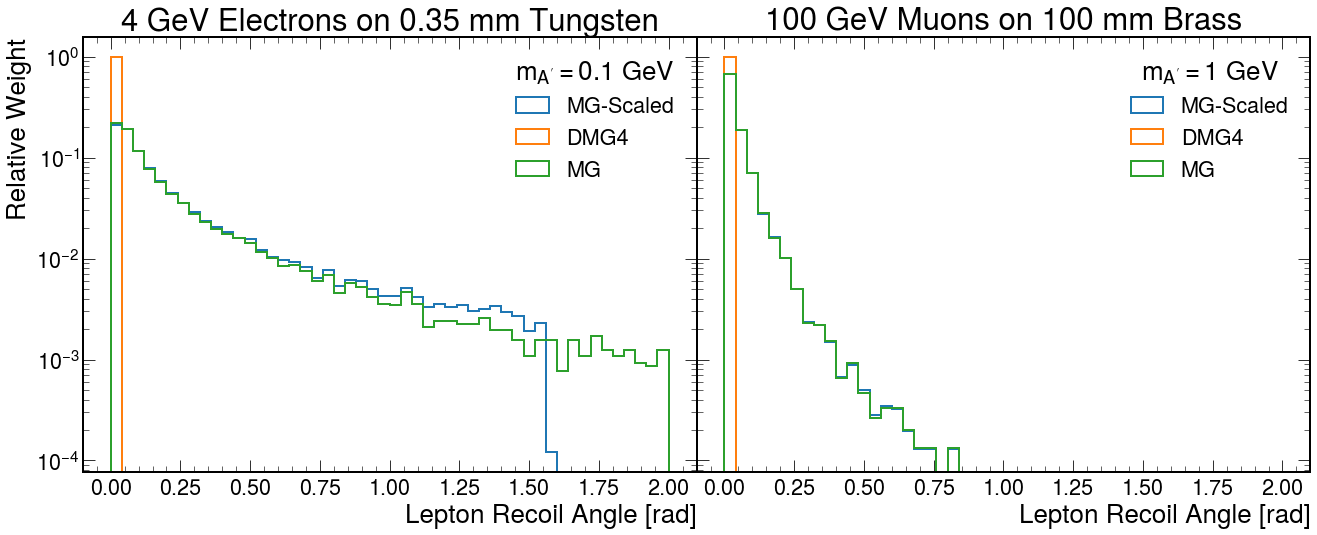

In [156]:
side_by_side(thin_tgt, 'recoil_angle', 'Lepton Recoil Angle [rad]',
             el_kwargs = { 'range' : (0., 2.), 'bins' : 50 }, mu_kwargs = { 'range' : (0.,2.), 'bins' : 50 })

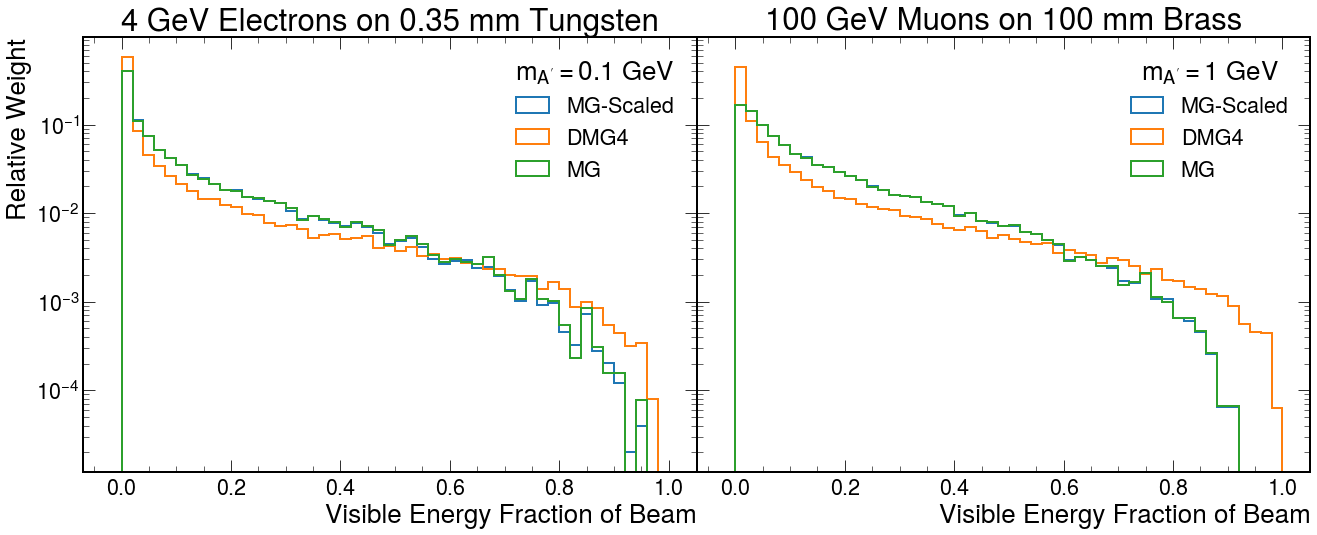

In [157]:
side_by_side(thin_tgt, 'visible_energy_frac', 'Visible Energy Fraction of Beam',
             el_kwargs = {'range' : (-0.02,1.), 'bins' : 51}, 
             mu_kwargs = {'range' : (-0.02,1.), 'bins' : 51})

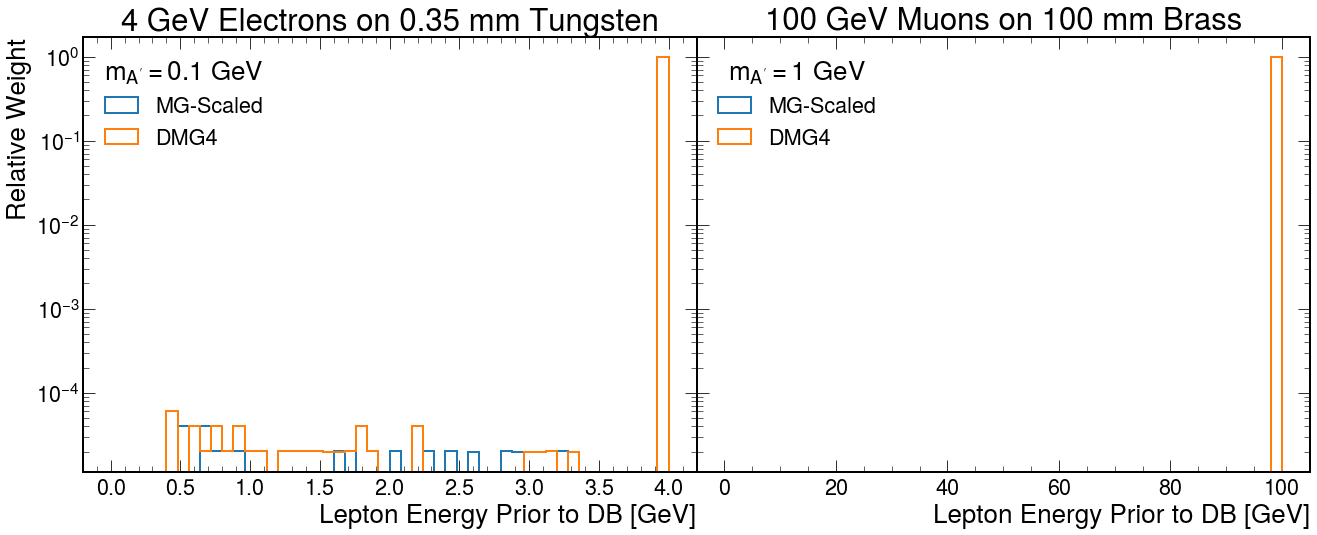

In [158]:
side_by_side(thin_tgt, 'incident_kinetic_energy_GeV', 'Lepton Energy Prior to DB [GeV]',
             el_kwargs = {'range' : (0.,4.000511), 'bins' : 50},
             mu_kwargs = {'range' : (0.,100.106) , 'bins' : 50},
             legend_kwargs = {'loc' : 'upper left'},
             drop_mg = True)

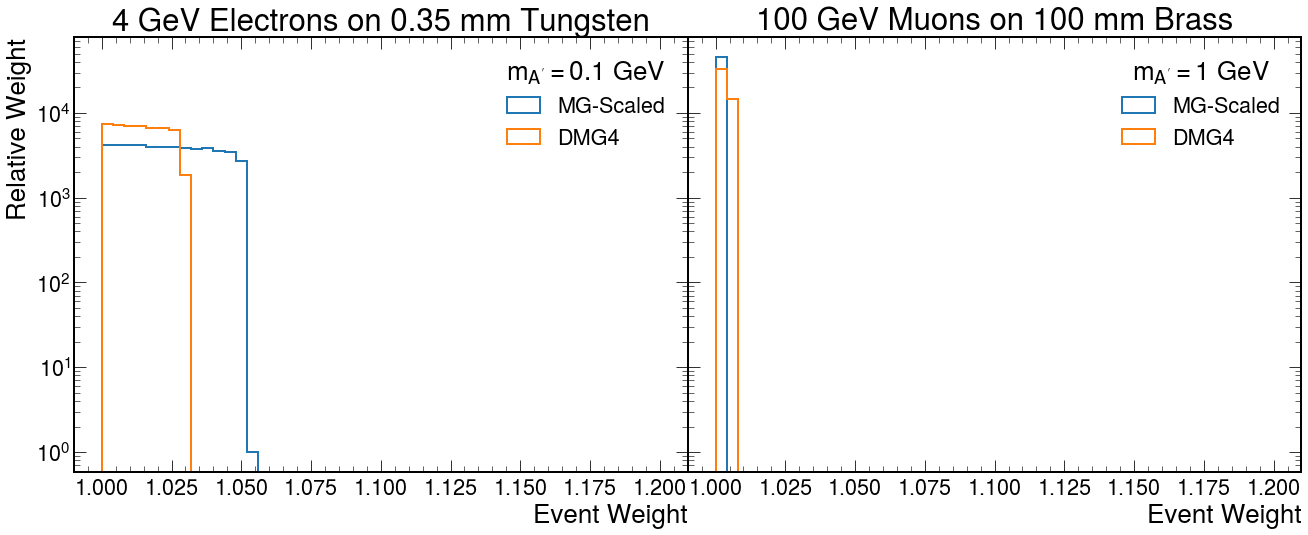

In [159]:
side_by_side(thin_tgt, 'relative_weight', 'Event Weight', weight = False,
             el_kwargs = {'range' : (1.,1.2), 'bins' : 50},
             mu_kwargs = {'range' : (1.,1.2), 'bins' : 50}, drop_mg = True)

## Thick Target
The thick target case is not able to be directly compared to MG since MG operates on a fixed-incident-energy basis. This does allow us to view how the two state-of-the-art models behave given their wildly different designs.

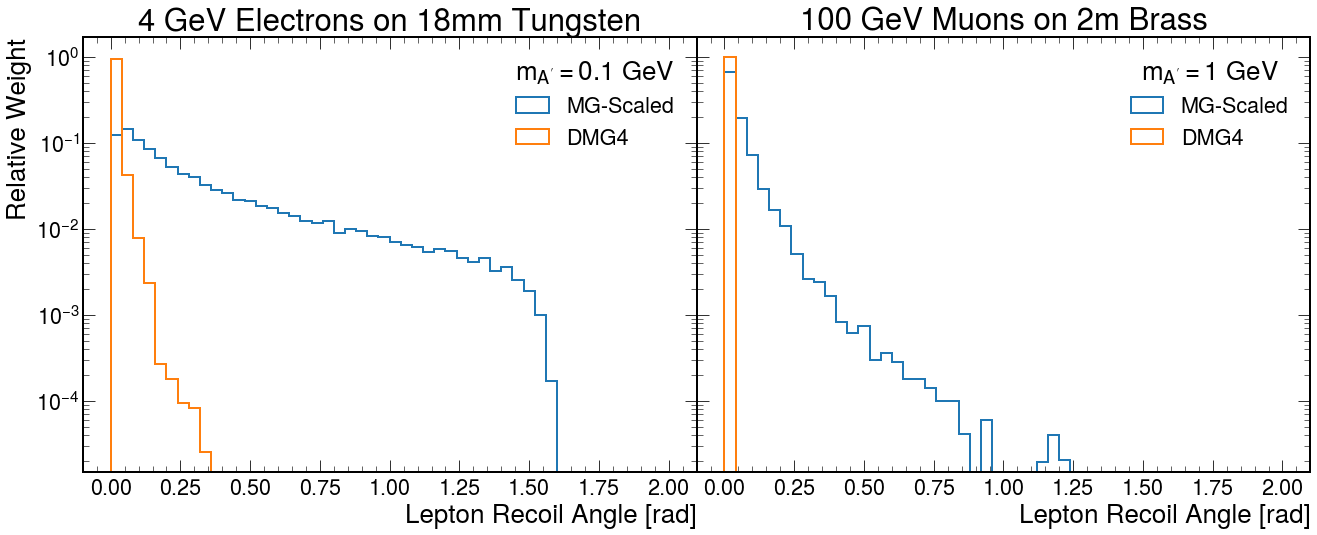

In [160]:
side_by_side(thick_tgt, 'recoil_angle', 'Lepton Recoil Angle [rad]',
             el_kwargs = { 'range' : (0.,2.), 'bins' : 50 }, 
             mu_kwargs = { 'range' : (0.,2.), 'bins' : 50 })

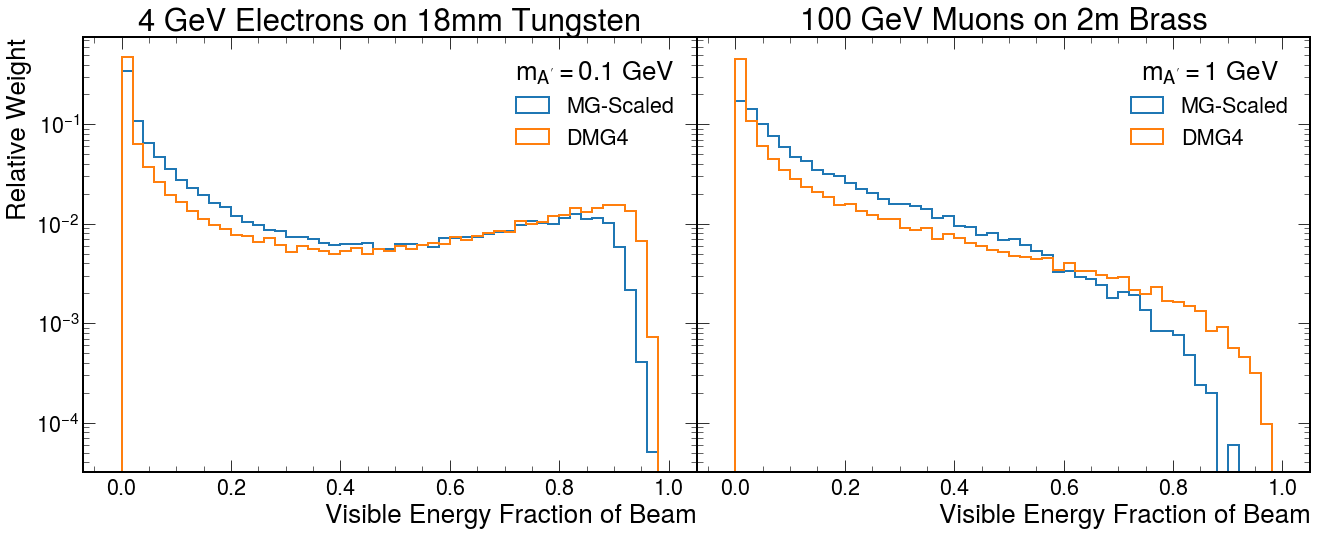

In [161]:
side_by_side(thick_tgt, 'visible_energy_frac', 'Visible Energy Fraction of Beam',
             el_kwargs = {'range' : (-0.02,1.), 'bins' : 51}, 
             mu_kwargs = { 'range' : (-0.02,1.), 'bins' : 51})

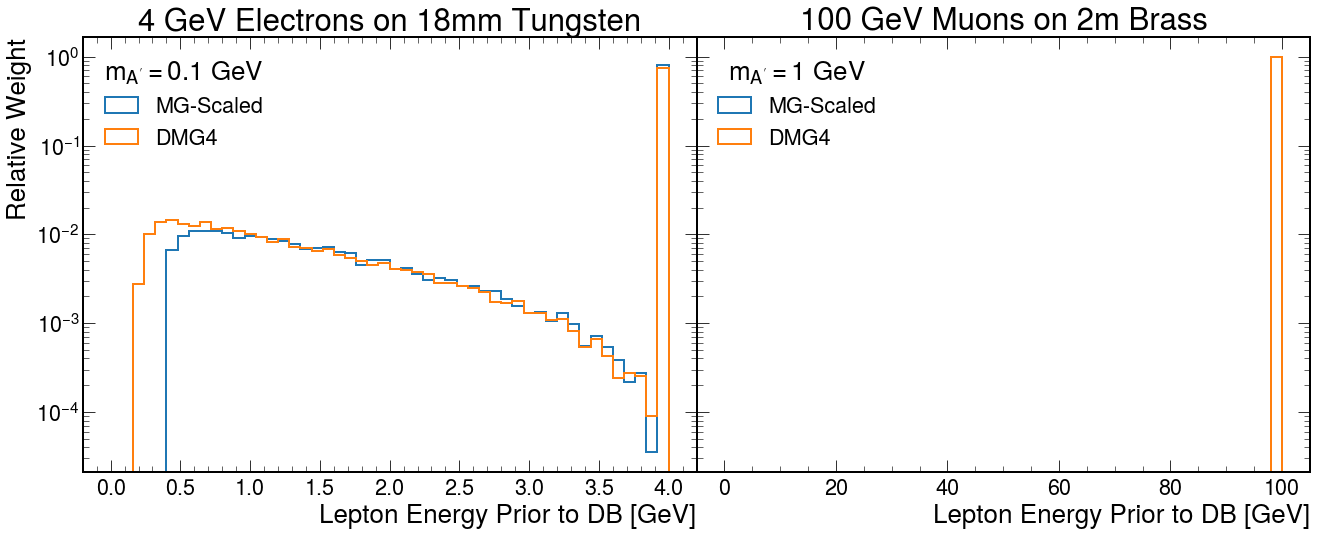

In [162]:
side_by_side(thick_tgt, 'incident_kinetic_energy_GeV', 'Lepton Energy Prior to DB [GeV]',
             el_kwargs = {'range' : (0.,4.000511), 'bins' : 50}, 
             mu_kwargs = { 'range' : (0.,100.106), 'bins' : 50},
             legend_kwargs = {'loc' : 'upper left'})

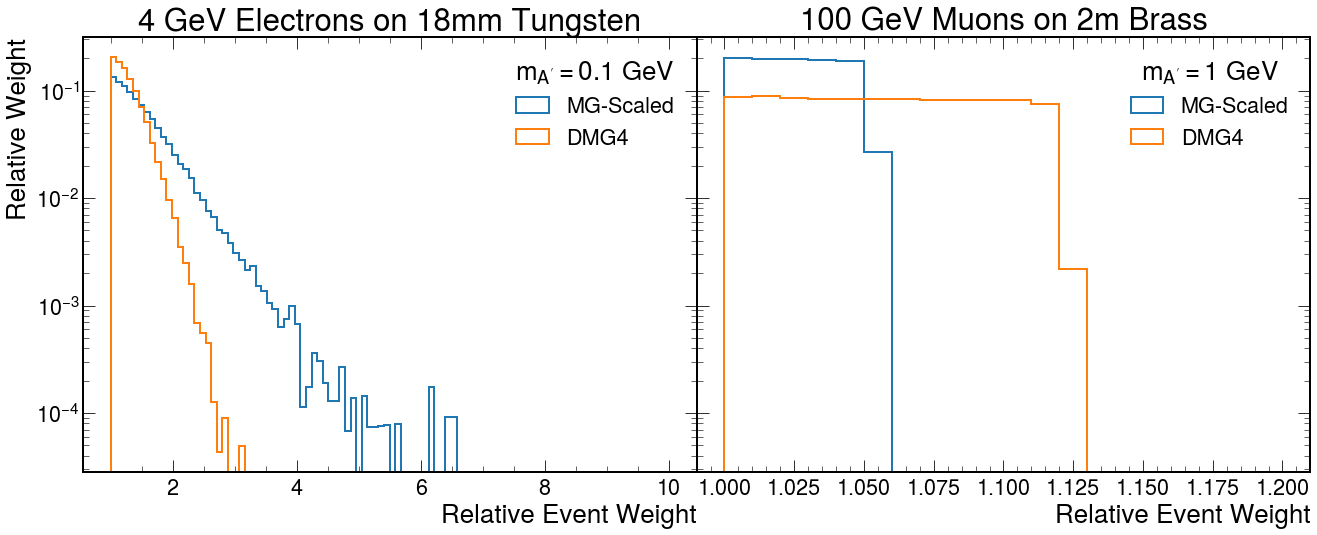

In [163]:
side_by_side(thick_tgt, 'relative_weight', 'Relative Event Weight',
             el_kwargs = {'range' : (1,10), 'bins' : 100},
             mu_kwargs = {'range' : (1,1.2), 'bins' : 20})